In [40]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import plotnine as gg
import matplotlib.pyplot as plt
%matplotlib inline

**THIS NOTEBOOK HAS FOLLOWING FUNCTIONS**

1- </b> CREATE BUFFER FIGURE  (BAR GRAPH)

2- REPAIR DERTMENT REPORT  (PIE CHART)

3- RADIO COUNTS (LINE GRAPH)

4- MBFT COUNTS  (LINE GRAPH)

In [41]:
topdir="Performance"
subdir='W47_2020'
figures = "figures"

## Directories and Filepath

In [42]:

def paths(topdir, subdir, figures):
    
    folderpath = os.path.join(Path("../", topdir), subdir)

    figpath = os.path.join(folderpath, figures)


    def create_folder(path):
             
        if not os.path.exists(path):
        
            print ("directory is created")
        
            return os.makedirs(path)
    
        else:
            
            return print ("directory is already existed")

    
    
    folder = create_folder(folderpath)

    figdir = create_folder(figpath)
    
    return folderpath, figpath


folderpath, figpath = paths(topdir, subdir, figures)
print(folderpath)
print(figpath)

directory is already existed
directory is already existed
../Performance/W47_2020
../Performance/W47_2020/figures


## Defining Paths

In [43]:
def csv_paths(folderpath):
    
    csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]
    
    apriso_path = [f for f in csvpath if "Apriso" in f][0]
    
    tracker_path = [f for f in csvpath if "Tracker" in f][0]
    
    buffer_path = [f for f in csvpath if "Buffer" in f][0]
    
    return apriso_path, tracker_path, buffer_path


apriso_path, tracker_path, buffer_path = csv_paths(folderpath)

print(apriso_path)
print(tracker_path)
print(buffer_path)


../Performance/W47_2020/Apriso_NOV22.csv
../Performance/W47_2020/Tracker_NOV22.csv
../Performance/W47_2020/Repair Department Buffer Report.csv


### Loading Data & Running function for creating buffer report

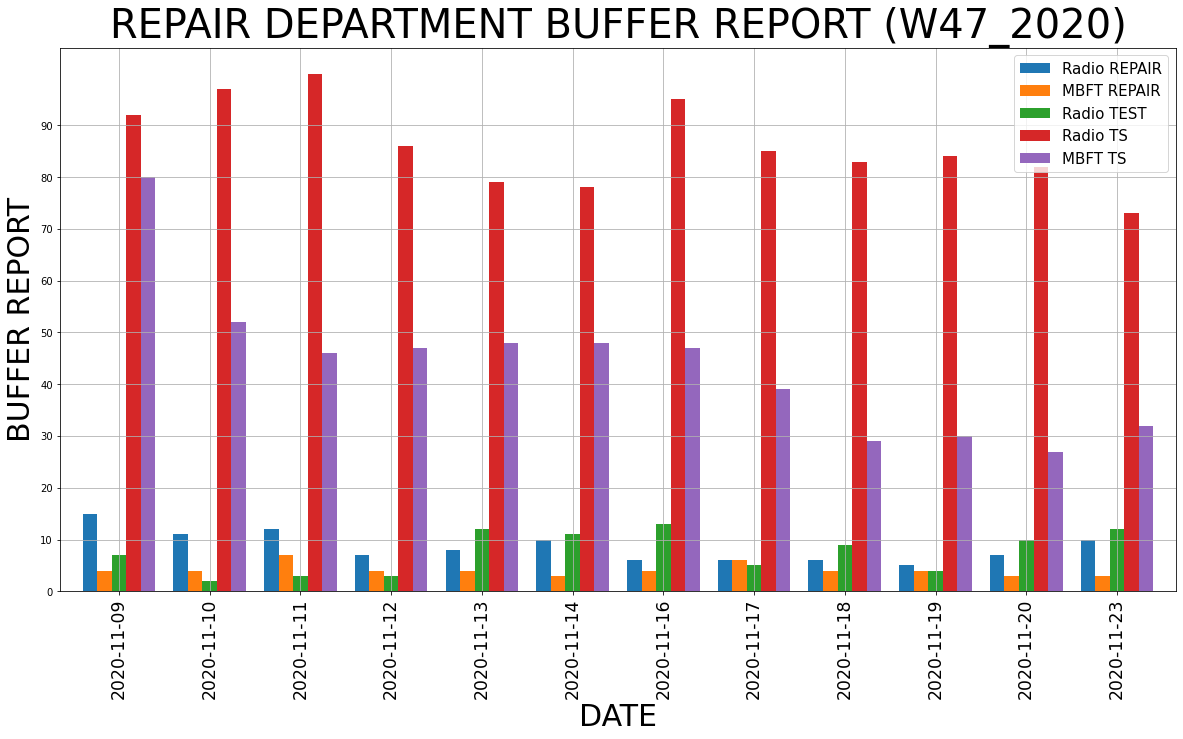

In [44]:
def buffer_figure(path, figpath):
    
    
    ''' path: path of data file
    
        figpath: path of saving figures
        
    '''
    data_buffer = pd.read_csv(path)
    
    
    ### Data preprocessing and converting DATE FORMAT and changed it string Format

    data_buffer['DATE'] = pd.to_datetime(data_buffer['DATE'], dayfirst = True)

    data_buffer['DATE'] = data_buffer['DATE'].astype(str)
    
    ### Plotting Figure
    
    
    plt.rcParams["figure.figsize"] = [20, 10]

    ax = data_buffer.plot.bar(x='DATE', y=list(data_buffer.columns[2:7]), width=0.8)

    plt.xlabel('DATE', fontsize=30)

    plt.ylabel('BUFFER REPORT', fontsize=30)

    ax.xaxis.set_tick_params(labelsize='xx-large')

    plt.title('REPAIR DEPARTMENT BUFFER REPORT' + ' (' + str(subdir) + ')', fontsize=40)

    plt.legend(fontsize=15)

    plt.grid()

    plt.yticks(np.arange(0, 100, 10))

    plt.savefig(os.path.join(figpath, 'REPAIR DEPARTMENT BUFFER REPORT_' + str(subdir) +'.png'), bbox_inches='tight')
    
    
    return ax




buffer_figure(buffer_path, figpath)



### Creating Merged dataframe which resulted after matching Tracker and Apriso Data

In [ ]:
def create_merged_csv(apriso_path, tracker_path, figpath):
    
    tracker_columns = ['DATE','RBU 6701_SN', 'FAIL Category', 'Fail Group', 
                       'TRSH NAME','STATUS', 'Notes', 'REPAIR Person',
                       'REPAIR NOTES', 'PRE-TRSH Person']

    data_tracker = (pd.read_csv(tracker_path, engine='python')
                    .loc[:, tracker_columns]
                   )
    
    
    apriso_columns = ['Serial #', 'Level 1', 'Level 2', 'Level 3', 'ProductNo']
    
    data_apriso = (pd.read_csv(apriso_path)
                   .loc[:, apriso_columns]
                  )


    data_apriso['RBU 6701_SN'] = data_apriso[data_apriso.columns[0:4]].apply(
        lambda x: ''.join(x.dropna().astype(str)),
        axis=1
    )
    
    data_apriso = (data_apriso.loc[:, ['RBU 6701_SN', 'ProductNo']])
    
    merged = data_tracker.merge(data_apriso, how='left', left_on='RBU 6701_SN', right_on= 'RBU 6701_SN')

    merged = merged.drop_duplicates()

        
    merged.loc[(merged['ProductNo'] == 'ROA1286713/1') & (merged['FAIL Category'] == 'RF'), 'FAIL Category'] = "MBFT"
    
    
    merged['RBU 6701_SN'] = merged['RBU 6701_SN'].str.replace("ea2a", "EA2A")
    
    
    merged['RBU 6701_SN'] = merged['RBU 6701_SN'].str.replace("e23", "E23")
    
    return merged

merged = create_merged_csv(apriso_path, tracker_path, figpath)

merged.head()

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3,9) have mixed types.Specify dtype option on import or set low_memory=False.



## Repair Department report



In [ ]:

def repair_department_report(merged, figpath):
    
    
    def status_ALT2(x):
        
        if (x['FAIL Category'] == "Mech.") & (x['STATUS'] == "ALT2"):
            return "ALT2"
        elif (x['FAIL Category'] == "Mech.") & (x['STATUS'] != "ALT2"):
            return "Mech."
    
        elif (x['FAIL Category'] == "SMA Repair") | (x['FAIL Category'] == "SMA REPAIR"):
            return "SMA Repair"
    
        elif (x['STATUS'] == "Pre-Scrap"):
            return "ROA Scrap"
    
        else:
            return x['FAIL Category']

        
    merged['Category'] = merged.apply(status_ALT2, axis=1)

    merged = merged.drop_duplicates(['RBU 6701_SN',"FAIL Category"], keep='last')

    merged = (merged.groupby('Category')
              .count()
              .reset_index()
              .loc[:, ['Category', 'DATE']]
              .rename(columns={'DATE': "Count"})
             )
    
    
    ## plotting pie chart
    
    
    plt.rcParams['font.size'] = 20


    labels = merged['Category'].unique()

    values = merged['Count'].values



    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(np.round(pct*total/100.0))
            return '{p:.1f}% \n [{v:d}]'.format(p=pct,v=val)
        return my_autopct


    mapping_colors = {'ALT2': '#f6e8c3',
                     'DIG.': '#fdae61',
                     'I.C.O. (TRSH)': '#ffffbf',
                     'MBFT': '#d73027',
                     'MVI': '#d9ef8b',
                     'Mech.': '#878787',
                     'RF': '#f46d43',
                     'ROA Scrap': '#de77ae',
                     'Re-work Order': '#e0e0e0',
                     'SMA Repair': '#3288bd',
                     'Validation Radio Test': '#c7eae5'}



    fig, ax = plt.subplots(figsize=(20, 10))
    ax.pie(values,labels=labels, colors = [mapping_colors[key] for key in labels], autopct=make_autopct(values),
            shadow=False, startangle=150, pctdistance=0.7, textprops={'color':"k", 
                                                                      'fontsize': 14}, 
           rotatelabels=False)
    # Equal aspect ratio ensures that pie is drawn as a circle

    plt.tight_layout()
    
    plt.title('Repair Department Weekly report' + ' (' + str(subdir) + ')')

              
    plt.savefig(os.path.join(figpath, 'piechart_Repair Department Weekly report_' + str(subdir) +'.png'), bbox_inches='tight')          
              
    return ax        
              
    
repair_department_report(merged, figpath)
    

    



## RADIO's REPORT

In [ ]:
def radio_report(merged, figpath):
    
    
    radios_type=["KRK10101/11", "KRK10101/21"]

    radios=["RF", "DIG."]

    tmp = (merged[merged['ProductNo'].isin(radios_type) & merged['FAIL Category'].isin(radios)]
            .groupby(['DATE','ProductNo'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','RBU 6701_SN']]
            .rename(columns={'RBU 6701_SN': "Count"})
          )
       


    tmp1 = (merged[merged['FAIL Category'].isin(radios)]
            .groupby(['DATE','RBU 6701_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL Category']]
            .rename(columns={'FAIL Category': "Count"})

          )




    tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)

    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()

    tmp['DATE'] = tmp['DATE'].astype(str)


    tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

    tmp1['DATE'] = tmp1['DATE'].astype(str)


    average_tmp = np.average(tmp['Count'])

    average_tmp1 = np.average(tmp1['Count'])




    from matplotlib.ticker import MaxNLocator
    plt.rcParams.update({'font.size': 15})



    fig, ax = plt.subplots(figsize=(20, 10))


    x = np.array(tmp['DATE'])
    y = np.array(tmp['Count'])

    y1 = np.array(tmp1['Count'])

    values = list(tmp1['Count'])
    values1 = list(tmp['Count'])

    plt.xlabel('DATE')
    plt.ylabel('RADIO COUNT')


    plt.title('REPAIR DEPARTMENT WEEKLY REPORT'+ ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS RADIO')
    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 50)

    plt.legend(['PASS RADIO', 'Avg. PASS RADIO','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()

    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_Radio_" + str(subdir) +'.png'))
    
    
    return ax

radio_report(merged, figpath)

## MBFT REPORT

In [ ]:

def mbft_report(merged, figpath):
    
    MBFT=["ROA1286713/1"]

    tmp = (merged[merged['ProductNo'].isin(MBFT) & merged['FAIL Category'].isin(['MBFT'])]
            .groupby(['DATE','ProductNo'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','RBU 6701_SN']]
            .rename(columns={'RBU 6701_SN': "Count"})
           )


    tmp1 = (merged[merged['FAIL Category'].isin(['MBFT'])]
            .groupby(['DATE','RBU 6701_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL Category']]
            .rename(columns={'FAIL Category': "Count"})

          )


    tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)

    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()

    tmp['DATE'] = tmp['DATE'].astype(str)


    tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

    tmp1['DATE'] = tmp1['DATE'].astype(str)


    average_tmp = np.average(tmp['Count'])

    average_tmp1 = np.average(tmp1['Count'])



    from matplotlib.ticker import MaxNLocator

    plt.rcParams.update({'font.size': 15})
    #plt.rcParams["figure.figsize"] = [20,9]


    fig, ax = plt.subplots(figsize=(20, 10))

    #fig.yaxis.set_major_locator(MaxNLocator(integer=True))

    x = np.array(tmp['DATE'])
    y = np.array(tmp['Count'])

    y1 = np.array(tmp1['Count'])

    values = list(tmp1['Count'])
    values1 = list(tmp['Count'])

    plt.xlabel('DATE')
    plt.ylabel('MBFT COUNT')


    plt.title('REPAIR DEPARTMENT WEEKLY REPORT' + ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS MBFT')
    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 25)

    plt.legend(['PASS MBFT', 'Avg. PASS MBFT','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()


    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_MBFT_" + str(subdir) +'.png'))
    
    
    return ax

mbft_report(merged, figpath)
    